In [1]:
import math
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from collections import defaultdict,Counter
from random import sample

In [152]:
class DecisionNode():
    '''
    Constructor for decision node
    attr - attribute to be tested on
    thresh - threshold for numerical attr, if categorical set to none
    children - dict mapping attr value to child, if numeric child keys are 'le' and 'gr'
    label - class label. default None, if not none, indicates that this is a leaf
    '''
    def __init__(self, attr, children, label=None, thresh=None):
        self.attr = attr
        self.children = children
        self.label = label
        self.thresh = thresh

def learn_tree(data,attr_list,do_ig,attr_vals,targets,min_size_split=0,min_gain=0.0,max_depth=-1,maj_prop=1.0):
    '''
    Function to create decision tree based on data
    do_ig - boolean, True to use info gain, False to use gini critereon
    attr_vals - dict, maps to array of possible values for each attr, empty if numeric
    targets - array, possible values for target class
    min_size_split - int, min number of instances required in data before returning a leaf node
    min_gain - float, min info gain to determine when to stop
    max_depth - int, if -1 no depth limit, else maximum depth before stopping 
    '''
    #if num data too small, return leaf
    if len(data) <= min_size_split:
        return DecisionNode(None,None,data['class'].mode()[0],None)
    #if max depth reached, return leaf
    if max_depth == 0:
        return DecisionNode(None,None,data['class'].mode()[0],None)

    if (data['class'].value_counts().iloc[0]/len(data)) >= maj_prop:
        return DecisionNode(None,None,data['class'].mode()[0],None)

    #find best attr from list using info gain
    max_gain = float('-inf')
    min_gini = float('inf')
    best_attr = ''

    random_attr = sample(attr_list,int(math.sqrt(len(attr_list))))

    for attr in random_attr:
        if do_ig:
            ig_attr,thresh = get_info_gain(data,attr,attr_vals[attr],targets)
            if ig_attr > max_gain:
                max_gain = ig_attr
                best_attr = attr
                best_thresh = thresh
        else:
            gini_attr = get_critereon(data,attr)
            if gini_attr < min_gini:
                min_gini = gini_attr
                best_attr = attr

    #if info gainf rom split not sufficient, return leaf
    #if max_gain < min_gain:
        #return DecisionNode(None,None,data['class'].mode()[0],None)

    if best_attr == '':
        return DecisionNode(None,None,data['class'].mode()[0],None)

    best_vals = attr_vals[best_attr]
    best_children = defaultdict(lambda: DecisionNode(None,None,data['class'].mode()[0],None))
    
    #if numeric attr
    if len(best_vals) == 0:
        best_children['le'] = learn_tree(data.loc[data[best_attr] <= best_thresh],attr_list,do_ig,attr_vals,targets,min_size_split,max_gain,max_depth-1,maj_prop) if len(data.loc[data[best_attr] <= best_thresh]) > 0 else DecisionNode(None,None,data['class'].mode()[0],None)
        best_children['gr'] = learn_tree(data.loc[data[best_attr] > best_thresh],attr_list,do_ig,attr_vals,targets,min_size_split,max_gain,max_depth-1,maj_prop) if len(data.loc[data[best_attr] > best_thresh]) > 0 else DecisionNode(None,None,data['class'].mode()[0],None)
    
    else:
        for i in best_vals:
            next_child = learn_tree(data.loc[data[best_attr] == i],attr_list,do_ig,attr_vals,targets,min_size_split,max_gain,max_depth-1,maj_prop) if len(data.loc[data[best_attr] == i]) > 0 else DecisionNode(None,None,data['class'].mode()[0],None)
            best_children[i] = next_child
            
    return DecisionNode(best_attr,best_children,thresh=best_thresh)


#Helper functions for decision tree
def get_info_gain(data,attr,num_cat,targets):
    split_entropy = 0
    if len(num_cat) > 0:
        best_split = None
        for i in num_cat:
            split_data = data.loc[data[attr] == i]
            split_entropy += (entropy(split_data,targets)*len(split_data))/len(data)
    else:
        best_split = data[attr].mean()
        split_entropy += split_thresh(data,attr,best_split,targets)

    return (entropy(data,targets) - split_entropy),best_split

#determine split threshhold for numeric attr
def split_thresh(data,attr,thresh,targets):
    if math.isnan(thresh):
        return entropy(data,targets)
    df_le = data.loc[data[attr] <= thresh]
    df_g = data.loc[data[attr] > thresh]
    return (entropy(df_le,targets)*len(df_le) + entropy(df_g,targets)*len(df_g))/len(data)

def entropy(data,targets):
    if len(data) == 0:
        return 0
    ent = 0
    for i in range(len(targets)):
        try:
            prob_i = data['class'].value_counts().iloc[i]/len(data)
            ent -= (prob_i * math.log(prob_i,2))
        except:
            pass
    return ent

def get_critereon(data,attr):
    data_0 = data.loc[data[attr] == 0]
    data_1 = data.loc[data[attr] == 1]
    data_2 = data.loc[data[attr] == 2]
    return (gini(data_0)*len(data_0) + gini(data_1)*len(data_1) + gini(data_2)*len(data_2))/len(data)

def gini(data):
    if len(data) == 0:
        return 0
    prob_0 = data['class'].value_counts().iloc[0]/len(data)
    crit = prob_0 ** 2
    if len(data['class'].value_counts()) > 1:
        prob_1 = data['class'].value_counts().iloc[1]/len(data)
        crit += prob_1 ** 2
    else:
        pass
    return crit

#function to classify an instance based on decision tree
def classify(instance,node):
    while node.label is None:
        if node.thresh is None:
            node = node.children[instance[node.attr]]
        else:
            node = node.children['le'] if instance[node.attr] <= node.thresh else node.children['gr']
    guess = node.label
    return guess

#wrapper fucntion for classify which takes all trees in forest, takes majority output and returns that guess
def ntree_classify(instance,ntree):
    votes = []
    for tree in ntree:
        votes.append(classify(instance,tree))
    count = Counter(votes)
    return count.most_common(1)[0][0]

#test accuracy on test data
def test_decision(to_test,targs,ntrees):
    predictions = pd.DataFrame(to_test.apply(lambda row: ntree_classify(row,ntrees), axis=1),columns = ['class'])
    predictions['actual'] = to_test.loc[predictions.index,['class']]
    prec,rec,f1 = [0,0,0]

    for val in targs:
        is_targ = predictions[predictions['class'] == val]
        not_targ = predictions[predictions['class'] != val]
        tp = len(is_targ[is_targ['class'] == is_targ['actual']])
        fp = len(is_targ[is_targ['class'] != is_targ['actual']])
        fn = len(not_targ[not_targ['actual'] == val])
        tn = len(not_targ[not_targ['actual'] != val])
        this_prec = (tp/(tp+fp)) if (tp+fp) > 0 else 0
        this_rec = (tp/(tp+fn)) if (tp+fn) > 0 else 0
        f1 += (this_prec*this_rec*2)/(this_rec+this_prec) if (this_rec+this_prec) > 0 else 0
        prec += this_prec
        rec += this_rec

    avg_prec = prec/len(targs)
    avg_rec = rec/len(targs)
    avg_f1 = f1/len(targs)
    accuracy = len(predictions[predictions['class'] == predictions['actual']])/len(to_test)
    return [accuracy,avg_prec,avg_rec,avg_f1]

np.random.seed(1)
k = 10
nvals = [1,5,10,20,30,40,50]
#function to do cross fold validation
def k_fold(fold,attr_list,attr_vals,targets,df):
    #maps n vals to list of average statistics for each 
    fold_metrics = defaultdict(list)
    #iterate through folds, taking turns being test fold
    for i in range(k):
        test_fold = fold[i]
        train_fold = fold[0:i]
        train_fold.extend(fold[i+1:len(fold)])
        train_data = pd.concat(train_fold)
        #vary number of trees for this fold
        for n in nvals:
            #list to store decisions of each tree by index
            ntree = []
            for j in range(n):
                #generate bootstrap w replacment
                bootstrap = train_data.sample(frac=1,replace=True)
                ntree.append(learn_tree(bootstrap,attr_list,True,attr_vals,targets))
            fold_metrics[n].append(test_decision(test_fold,df,targets,ntree))
    return fold_metrics

In [148]:
np.random.seed(1)
k = 10
nvals = [1,5,10,20,30,40,50]
wine_df = pd.read_csv('datasets/hw3_wine.csv',delim_whitespace=True)
wine_attr = defaultdict(list)
attr_list = list(wine_df.columns.values)
attr_list.remove('class')
wine_targets = [1,2,3]

#split data by class into k groups then combine into folds
wine_class_1 = wine_df.loc[wine_df['class'] == 1].sample(frac=1)
wc1_split = np.array_split(wine_class_1,k)
wine_class_2 = wine_df.loc[wine_df['class'] == 2].sample(frac=1)
wc2_split = np.array_split(wine_class_2,k)
wine_class_3 = wine_df.loc[wine_df['class'] == 3].sample(frac=1)
wc3_split = np.array_split(wine_class_3,k)

#list to hold folds
wine_fold = []
for i in range(k):
    this_fold = [wc1_split[i],wc2_split[i],wc3_split[i]]
    wine_fold.append(pd.concat(this_fold))

fold_metrics_wine = k_fold(wine_fold,attr_list,wine_attr,wine_targets,wine_df)

In [158]:
#maps n vals to list of average statistics for each 
fold_metrics = defaultdict(list)
#iterate through folds, taking turns being test fold
for i in range(k):
    test_fold = wine_fold[i]
    train_fold = wine_fold[0:i]
    train_fold.extend(wine_fold[i+1:len(wine_fold)])
    train_data = pd.concat(train_fold)
    #vary number of trees for this fold
    for n in nvals:
        #list to store decisions of each tree by index
        ntree = []
        for j in range(n):
            #generate bootstrap w replacment
            bootstrap = train_data.sample(frac=1,replace=True,random_state=1)
            ntree.append(learn_tree(bootstrap,attr_list,True,wine_attr,wine_targets,max_depth=7,min_size_split=10,maj_prop=0.85))
        fold_metrics[n].append(test_decision(test_fold,wine_targets,ntree))

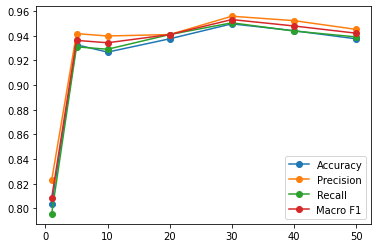

In [159]:
n_acc = []
n_prec = []
n_rec = []
n_f1 = []

for n,perf in fold_metrics.items():
    avg_accuracy,avg_prec,avg_rec,avg_f1 = [0,0,0,0]
    for res in perf:
        avg_accuracy += res[0]
        avg_prec += res[1]
        avg_rec += res[2]
        avg_f1 += res[3]
    n_acc.append(avg_accuracy/10)
    n_prec.append(avg_prec/10)
    n_rec.append(avg_rec/10)
    n_f1.append(avg_f1/10)

plt.plot(nvals,n_acc,label='Accuracy',marker='o')
plt.plot(nvals,n_prec,label='Precision',marker='o')
plt.plot(nvals,n_rec,label='Recall',marker='o')
plt.plot(nvals,n_f1,label='Macro F1',marker='o')
plt.legend()

In [21]:
np.random.seed(1)
k = 10
#np.random.seed(1)
nvals = [1,5,10]
house_df = pd.read_csv('datasets/hw3_house_votes_84.csv')
#house_attr = defaultdict(lambda: [0,1,2])
house_attr_list = list(house_df.columns.values)
house_attr_list.remove('class')
house_attr = {key: [0,1,2] for key in house_attr_list}
house_targets = [0,1]
#split data by class into k groups then combine into folds
house_class_1 = house_df.loc[house_df['class'] == 0].sample(frac=1)
hc1_split = np.array_split(house_class_1,k)
house_class_2 = house_df.loc[house_df['class'] == 1].sample(frac=1)
hc2_split = np.array_split(house_class_2,k)

#list to hold folds
house_fold = []
for i in range(k):
    this_fold = [hc1_split[i],hc2_split[i]]
    house_fold.append(pd.concat(this_fold))

In [22]:
#maps n vals to list of average statistics for each 
fold_metrics_house = defaultdict(list)
#iterate through folds, taking turns being test fold
for i in range(k):
    test_fold_h = house_fold[i]
    train_fold_h = house_fold[0:i]
    train_fold_h.extend(house_fold[i+1:len(house_fold)])
    train_data_h = pd.concat(train_fold_h)
    #vary number of trees for this fold
    for n in nvals:
        #list to store decisions of each tree by index
        ntree = []
        for j in range(n):
            #generate bootstrap w replacment
            bootstrap = train_data_h.sample(frac=1,replace=True)
            ntree.append(learn_tree(bootstrap,house_attr_list,True,house_attr,house_targets))
        fold_metrics_house[n].append(test_decision(test_fold_h,house_df,house_targets,ntree))

In [ ]:
def k_fold(fold,attr_list,attr_vals,targets,df):
    #maps n vals to list of average statistics for each 
    fold_metrics = defaultdict(list)
    #iterate through folds, taking turns being test fold
    for i in range(k):
        test_fold = fold[i]
        train_fold = fold[0:i]
        train_fold.extend(fold[i+1:len(fold)])
        train_data = pd.concat(train_fold)
        #vary number of trees for this fold
        for n in nvals:
            #list to store decisions of each tree by index
            ntree = []
            for j in range(n):
                #generate bootstrap w replacment
                bootstrap = train_data.sample(frac=1,replace=True)
                ntree.append(learn_tree(bootstrap,attr_list,True,attr_vals,targets))
            fold_metrics[n].append(test_decision(test_fold,df,targets,ntree))
    return fold_metrics

In [23]:
n_acc = []
n_prec = []
n_rec = []
n_f1 = []

for n,perf in fold_metrics_house.items():
    avg_accuracy,avg_prec,avg_rec,avg_f1 = [0,0,0,0]
    for res in perf:
        avg_accuracy += res[0]
        avg_prec += res[1]
        avg_rec += res[2]
        avg_f1 += res[3]
    n_acc.append(avg_accuracy/10)
    n_prec.append(avg_prec/10)
    n_rec.append(avg_rec/10)
    n_f1.append(avg_f1/10)

plt.plot(nvals,n_acc,label='Accuracy',marker='o')
plt.plot(nvals,n_prec,label='Precision',marker='o')
plt.plot(nvals,n_rec,label='Recall',marker='o')
plt.plot(nvals,n_f1,label='Macro F1',marker='o')
plt.legend()